In [152]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [153]:
def show_image(window_name, image, time=0):
    """
    绘图函数，按Esc健关闭绘图窗口
    """
    # 解决uint16的问题
    if image.dtype == np.uint16:
        image = cv2.convertScaleAbs(image, alpha=(255.0/65535.0))

    
    ## py文件用下面的显示代码
    # cv2.imshow(window_name, image)
    # if cv2.waitKey(time) or 0xFF == 27:  # ESC按键
    #     cv2.destroyAllWindows()


    ## jupyter用如下
    try:
        # 如果是彩色图像，转为 RGB 格式
        if image.shape[2] == 3:
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    except:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    plt.imshow(image)
    plt.show()

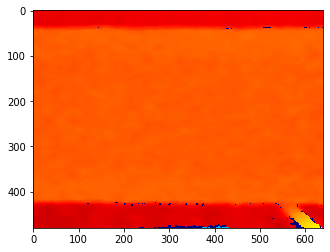

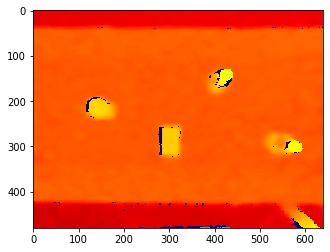

In [154]:
backgroud_depth = cv2.imread('2020_11_10_15_31_13aligned_depth_.png',cv2.IMREAD_UNCHANGED)
backgroud_depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(backgroud_depth, alpha=0.2), cv2.COLORMAP_JET)
show_image('',backgroud_depth_colormap)

object_depth = cv2.imread('2020_11_10_15_30_41aligned_depth_.png',cv2.IMREAD_UNCHANGED)
object_depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(object_depth, alpha=0.2), cv2.COLORMAP_JET)
show_image('',object_depth_colormap)
cv2.imwrite('object_depth_colormap.png',object_depth_colormap)

# 全部深度相减
object_mask_all = cv2.subtract(backgroud_depth,object_depth)

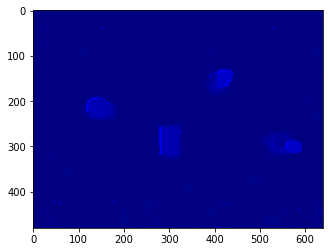

In [155]:
# 提取30cm内的有效深度差
object_mask = cv2.convertScaleAbs(object_mask_all, alpha=0.85)
object_mask_colormap = cv2.applyColorMap(cv2.convertScaleAbs(object_mask, alpha=0.1), cv2.COLORMAP_JET)
show_image('',object_mask_colormap)

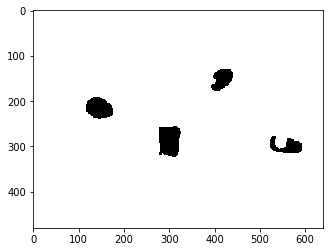

(480, 640, 3)


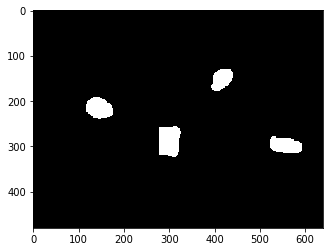

In [170]:
# 二值化提取物体掩码
ret, thresh = cv2.threshold(object_mask,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# 滤去传送带上杂波
kernel_1 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_1,iterations=1)
show_image('',thresh)

# 滤去传送带边缘杂波
thresh[0:50,0:640] = 255
thresh[410:480,0:640] = 255

# 使轮廓区域更加完整
kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT,(25,25))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_2,iterations=1)

# 黑白反转
thresh = cv2.bitwise_not(thresh) 
show_image('',thresh)


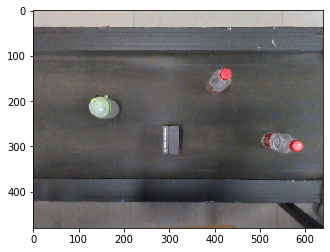

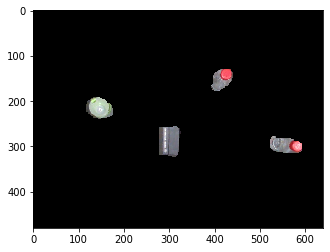

In [157]:
# 和原始图像合并
object_color = cv2.imread('2020_11_10_15_30_41aligned_color_image.png')
show_image('',object_color)
img_with_mask = cv2.bitwise_and(object_color,object_color,mask=thresh)
show_image('',img_with_mask)

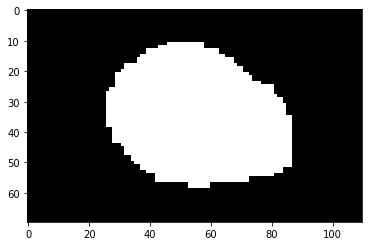

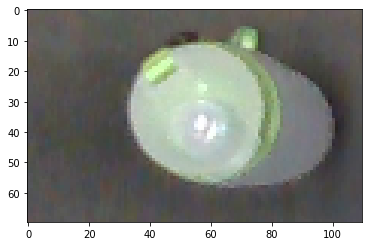

In [158]:
object_1_mask = thresh[180:250,90:200]
object_1_color = object_color[180:250,90:200]
show_image('',object_1_mask)
show_image('',object_1_color)

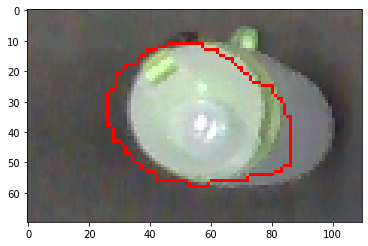

In [159]:
_, contours, _ = cv2.findContours(object_1_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
res = cv2.drawContours(object_1_color,contours,-1,(0,0,255),1)
# 显示出所有轮廓
show_image('res',object_1_color)

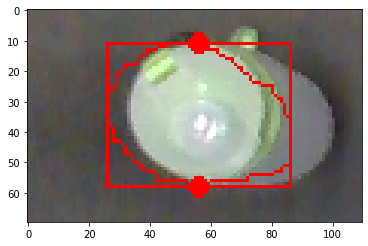

In [160]:
cnt = contours[-1]
rect = cv2.minAreaRect(cnt)
box = np.int0(cv2.boxPoints(rect))
box = box

# 从较细的地方抓取
# 通过长度判断哪里比较细
line_12 = rect[1][0]
line_01 = rect[1][1]
if line_01>line_12:
    start = 0.5*(box[0]+box[1])
    start = tuple(start.astype(int))
    end = 0.5*(box[2]+box[3])
    end = tuple(end.astype(int))
else:
    start = 0.5*(box[0]+box[3])
    start = tuple(start.astype(int))
    end = 0.5*(box[2]+box[1])
    end = tuple(end.astype(int))

# 继续画图
object_1_color = cv2.line(object_1_color,tuple(box[0]),tuple(box[1]),(0,0,255),thickness=1)
object_1_color = cv2.line(object_1_color,tuple(box[1]),tuple(box[2]),(0,0,255),thickness=1)
object_1_color = cv2.line(object_1_color,tuple(box[2]),tuple(box[3]),(0,0,255),thickness=1)
object_1_color = cv2.line(object_1_color,tuple(box[3]),tuple(box[0]),(0,0,255),thickness=1)
object_1_color = cv2.circle(object_1_color,start,2,(0,0,255),2)
object_1_color = cv2.circle(object_1_color,end,2,(0,0,255),2)
show_image('final',object_1_color)

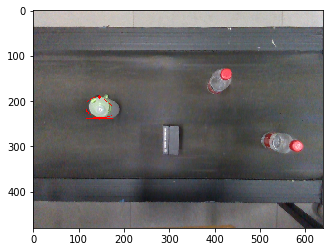

In [161]:
object_color[180:250,90:200] = object_1_color
show_image('',object_color)

In [162]:
cv2.imwrite('test.png',object_color)

True

(480, 640, 3)


True